# Setups and Imports

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer
from pathlib import Path
from sklearn import datasets
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

#global settings
SEED = 42
np.random.seed(SEED)
VIS_DIR = Path("visuals"); VIS_DIR.mkdir(parents=True, exist_ok=True)
plt.rcParams["figure.dpi"] = 160


# Loading Breast Cancer Dataset

In [42]:
dataset_bc = datasets.load_breast_cancer() #Wisconsin Diagnostic Breast Cancer dataset from scikit-learn. This ships with scikit-learn so no external download is required
df = pd.DataFrame(dataset_bc.data[:, :], columns=dataset_bc.feature_names) #conversion from numpy to pandas df for easier EDA and plotting
y = pd.Series(dataset_bc.target, name="Target")  #0=malignant, 1=benign
df["Target"] = y

# Preprocessing and Train/Test Split

In [43]:
#sanity checks
display(df.head())
display(df.describe().T)
#no missing values expected, but checking anyway
display(df.isna().sum().sort_values(ascending=False).head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


,0
mean radius,0
mean texture,0
mean perimeter,0
mean area,0
mean smoothness,0


##Scaling

In [44]:
#scaling only features, not target
scaler = MinMaxScaler()
df.loc[:, dataset_bc.feature_names] = scaler.fit_transform(df.loc[:, dataset_bc.feature_names])

##Splitting

In [45]:
X = df[dataset_bc.feature_names]
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)

#Exploratory Data Analysis (EDA)

## Class Distribution

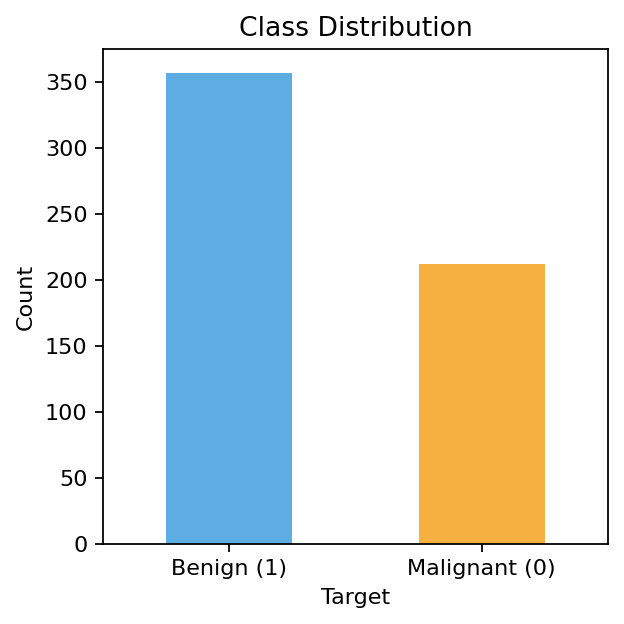

In [62]:
#visualising target imbalance
plt.figure(figsize=(4,4))
y.value_counts().plot(kind="bar", color=["#5DADE2", "#F5B041"])
plt.xticks([0,1], ["Benign (1)", "Malignant (0)"], rotation=0)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(VIS_DIR / "00_class_distribution.png", bbox_inches="tight")
plt.show()


# Correlation Heatmaps

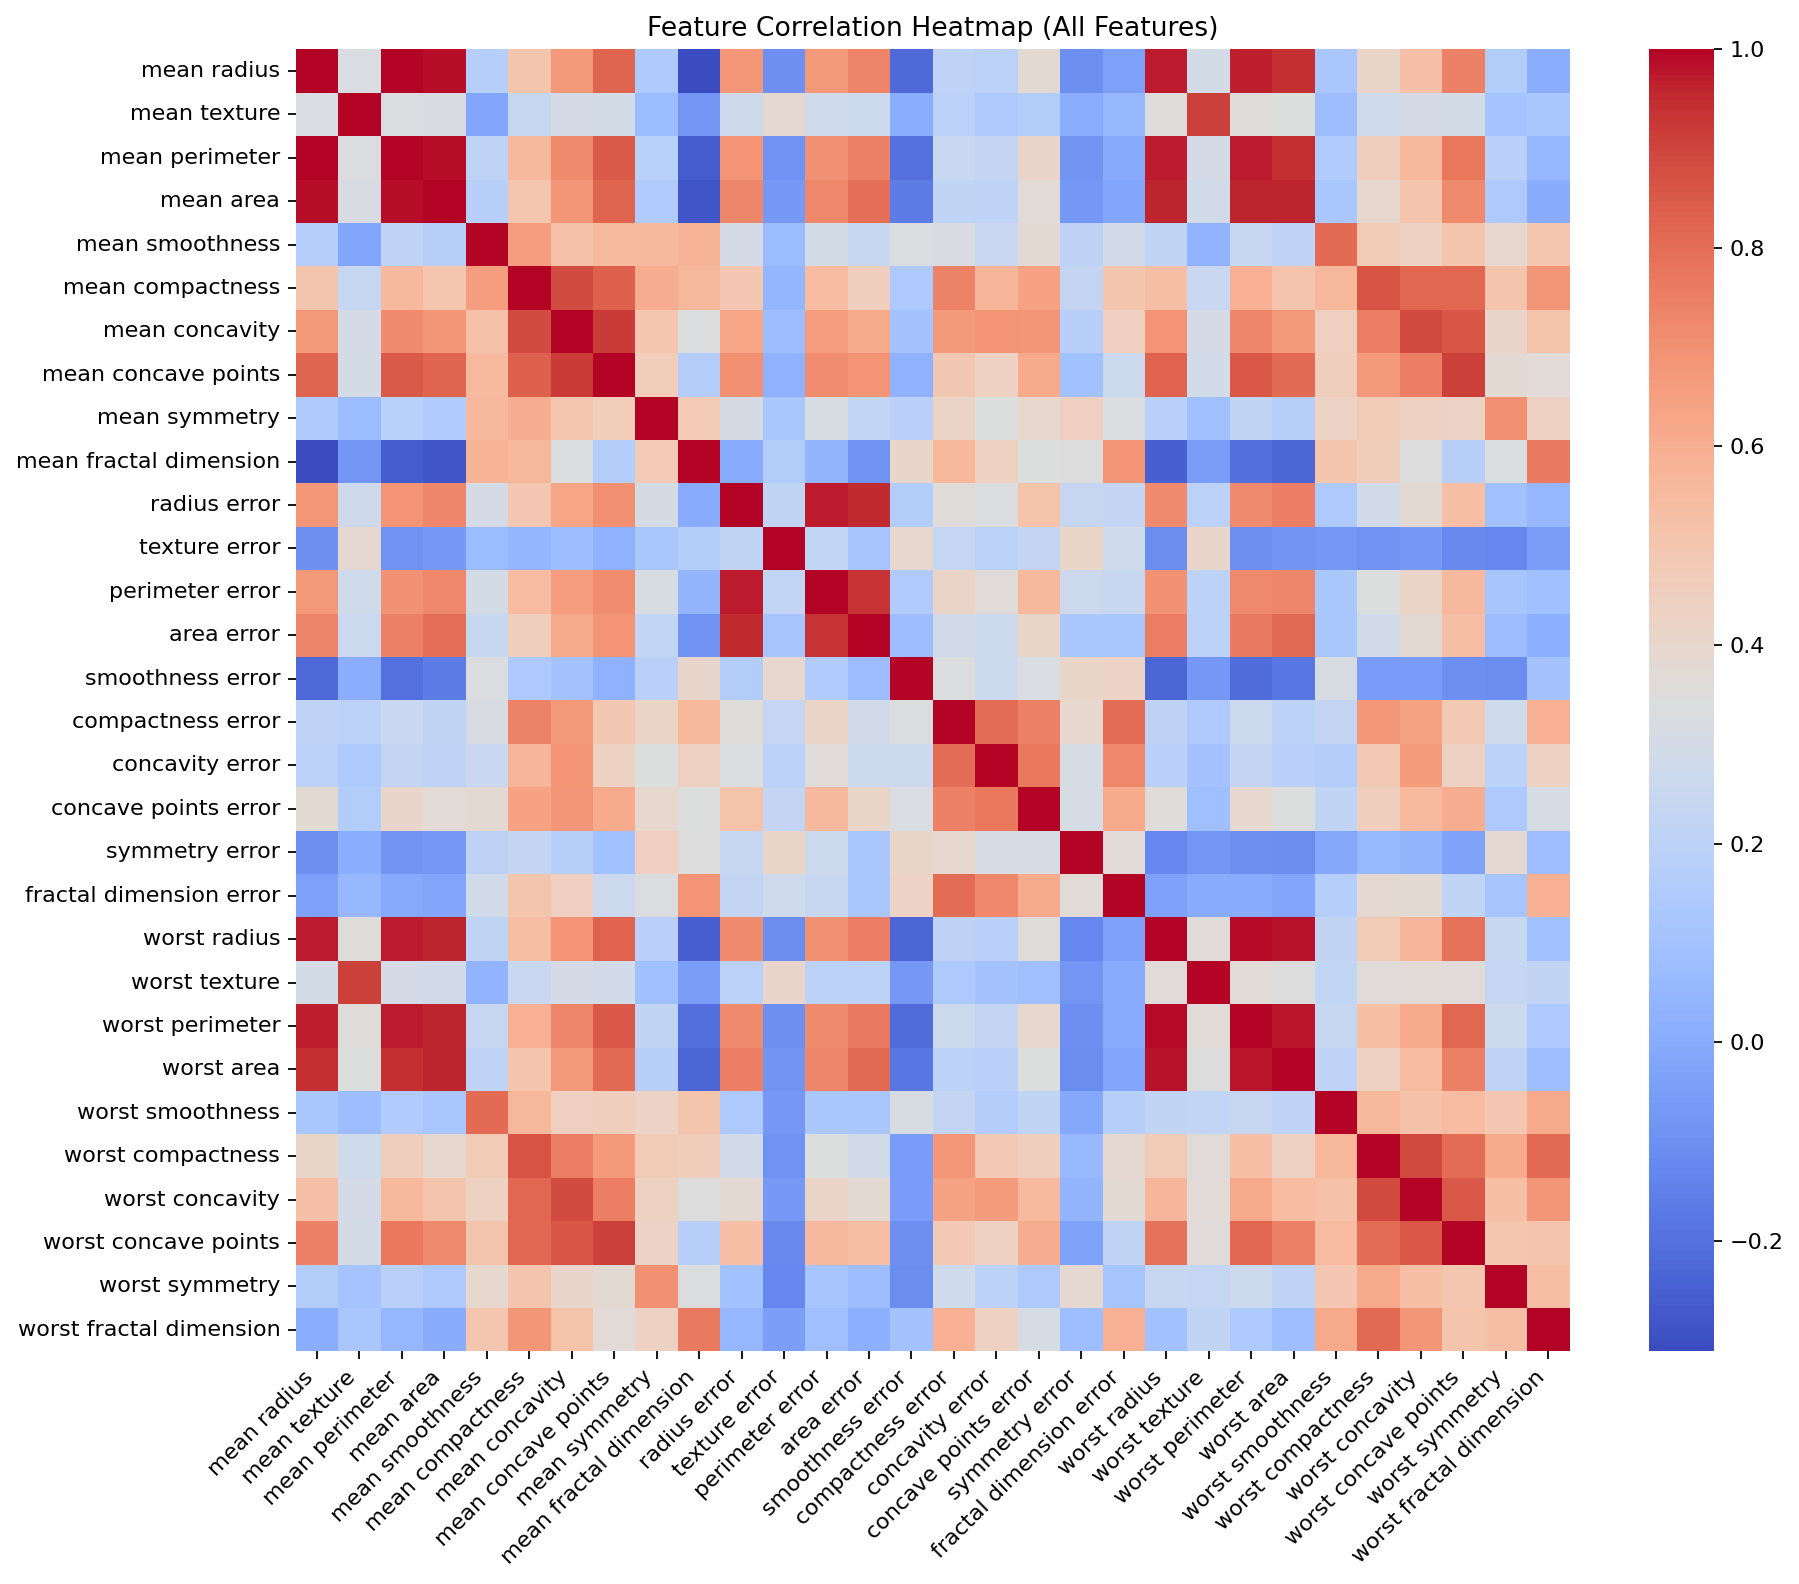

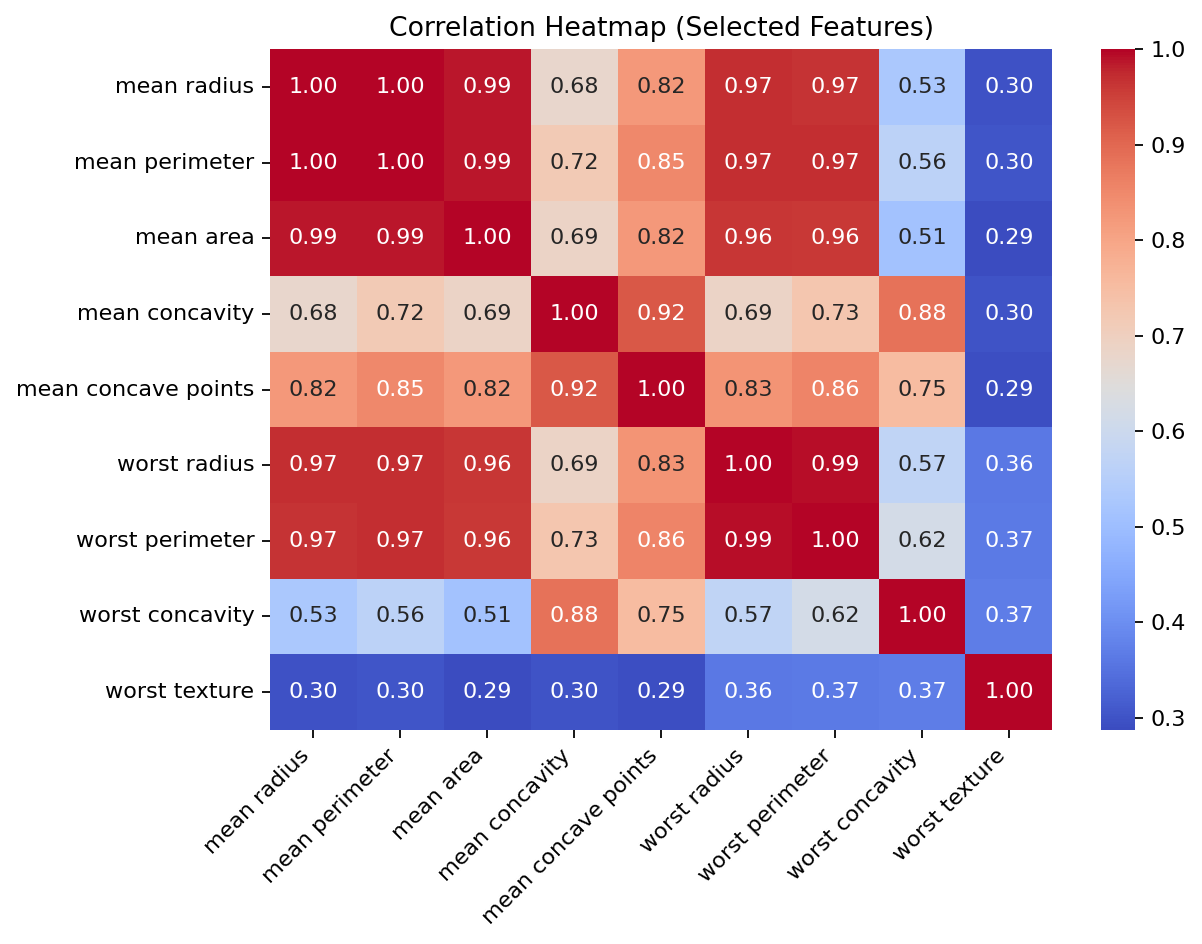

In [46]:
#full correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df[dataset_bc.feature_names].corr(), cmap="coolwarm", cbar=True, annot=False)
plt.title("Feature Correlation Heatmap (All Features)")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.savefig(VIS_DIR / "01_corr_full.png", bbox_inches="tight"); plt.show()

#correlation heatmap of selected features
subset = [
    "mean radius", "mean perimeter", "mean area",
    "mean concavity", "mean concave points",
    "worst radius", "worst perimeter", "worst concavity",
    "worst texture"
]
plt.figure(figsize=(8,6))
sns.heatmap(df[subset].corr(), cmap="coolwarm", cbar=True, annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Selected Features)")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.savefig(VIS_DIR / "01_corr_subset.png", bbox_inches="tight"); plt.show()


##Feature Distributions by Class (Boxplots)

/tmp/ipython-input-1601391623.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Target", y=f, data=df, palette="Set2")


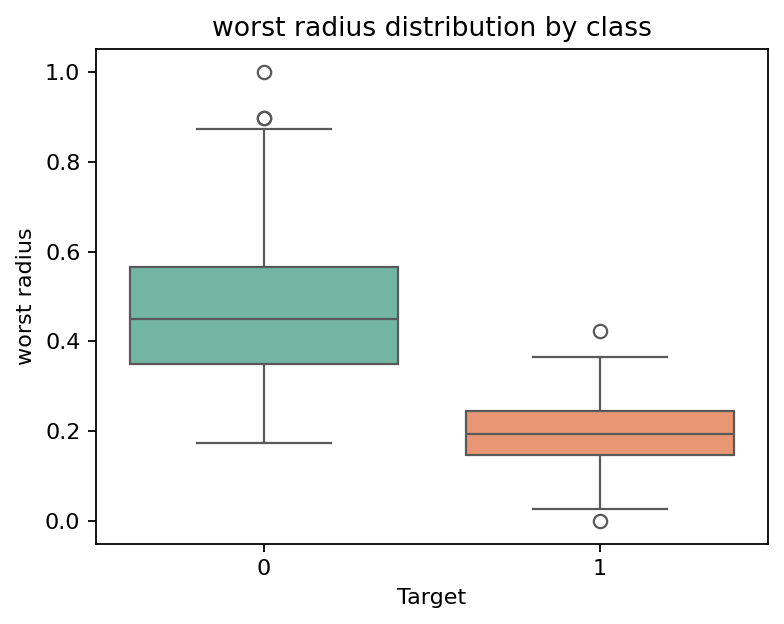

/tmp/ipython-input-1601391623.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Target", y=f, data=df, palette="Set2")


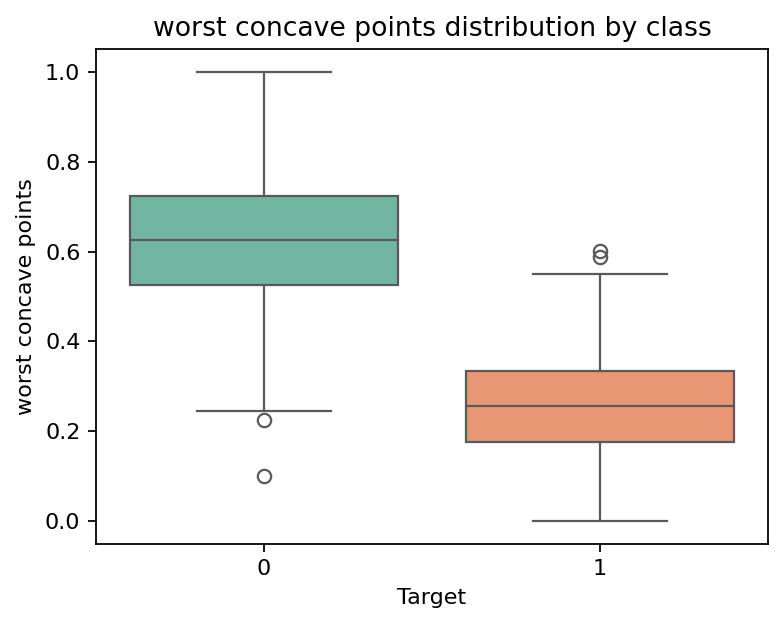

/tmp/ipython-input-1601391623.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Target", y=f, data=df, palette="Set2")


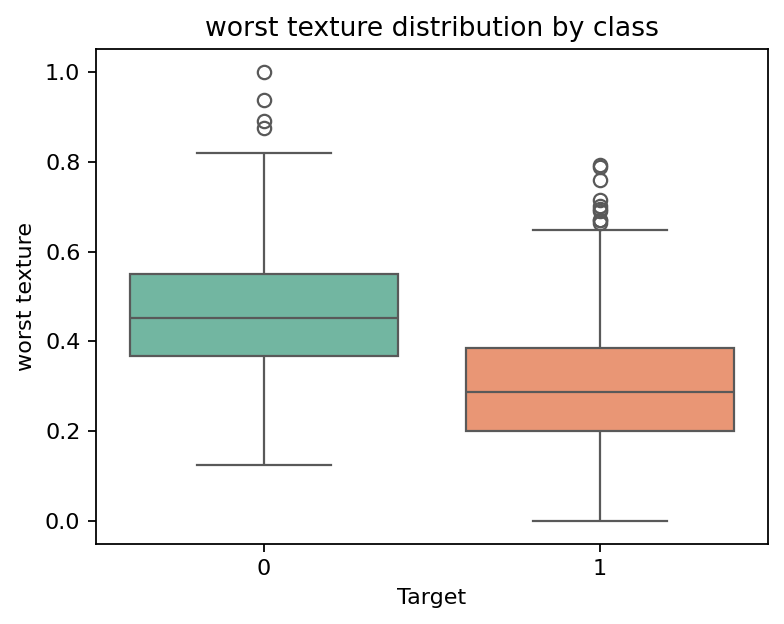

In [58]:
#showing distribution by class
top_feats = ["worst radius", "worst concave points", "worst texture"]
for f in top_feats:
    plt.figure(figsize=(5,4))
    sns.boxplot(x="Target", y=f, data=df, palette="Set2")
    plt.title(f"{f} distribution by class")
    plt.tight_layout()
    plt.savefig(VIS_DIR / f"eda_{f.replace(' ','_')}_boxplot.png", bbox_inches="tight")
    plt.show()


#Feature Selection with RFECV

In [47]:
#feature selection (stable): RFECV over 10-fold CV using a Decision Tree
SEED = 42

#using a plain DecisionTree here just as the RFECV estimator
rfecv = RFECV(
    estimator=DecisionTreeClassifier(random_state=SEED),
    step=1,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED),
    scoring="f1",
    n_jobs=-1
)

#fitting on training data only
rfecv.fit(X_train, y_train)

selected_feats = X_train.columns[rfecv.support_].tolist()
print(f"RFECV selected {len(selected_feats)} features:")
print(selected_feats)

#reducing to selected features for all downstream steps
Xtr_sel = X_train[selected_feats].copy()
Xte_sel = X_test[selected_feats].copy()


RFECV selected 3 features:
['worst radius', 'worst texture', 'worst concave points']


In [71]:
print(len(selected_feats), selected_feats[:10])
assert set(Xtr_sel.columns) == set(selected_feats)
assert set(Xte_sel.columns) == set(selected_feats)


3 ['worst radius', 'worst texture', 'worst concave points']


# Decision Tree with SMOTE (Pipeline + GridSearchCV)

In [55]:
# Pipeline: SMOTE -> DecisionTree
pipe = Pipeline(steps=[
    ("smote", SMOTE(random_state=SEED)),
    ("clf", DecisionTreeClassifier(random_state=SEED))
])

#grid is kept modest for speed
param_grid = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [None, 4, 6, 8, 10],
    "clf__min_samples_leaf": [1, 3, 5, 7],
    "clf__max_leaf_nodes": [None, 8, 10, 12],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

#fitting on the training split (selected features only)
grid.fit(Xtr_sel, y_train)

print("Best params:", grid.best_params_)
best = grid.best_estimator_


Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__max_leaf_nodes': None, 'clf__min_samples_leaf': 1}


#Final Evaluation (Classification report, Confusion matrix, ROC)

              precision    recall  f1-score   support

           0      0.906     0.906     0.906        64
           1      0.944     0.944     0.944       107

    accuracy                          0.930       171
   macro avg      0.925     0.925     0.925       171
weighted avg      0.930     0.930     0.930       171

{'accuracy': 0.9298, 'precision': 0.9439, 'recall': 0.9439, 'f1': 0.9439, 'roc_auc': np.float64(0.9504)}


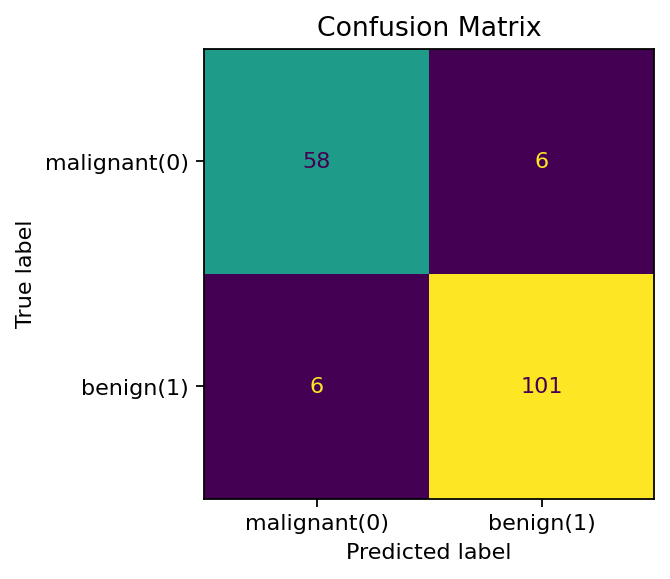

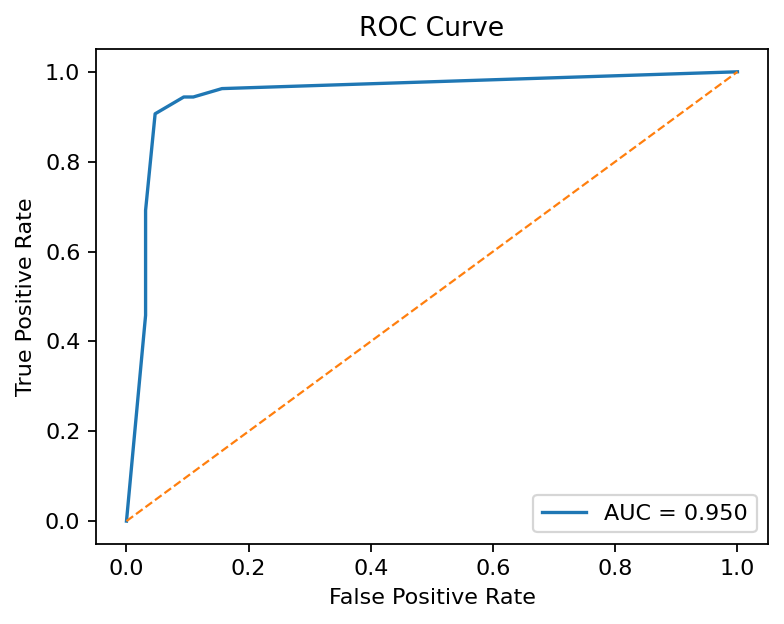

In [49]:
VIS_DIR = Path("visuals")
VIS_DIR.mkdir(parents=True, exist_ok=True)

#predicting probabilities for ROC; threshold at 0.5 for class labels
y_prob = best.predict_proba(Xte_sel)[:, 1]  #prob of class "1" (benign in sklearn dataset)
y_pred = (y_prob >= 0.5).astype(int)

#text report
print(classification_report(y_test, y_pred, digits=3))
print({
    "accuracy":  round(accuracy_score(y_test, y_pred), 4),
    "precision": round(precision_score(y_test, y_pred), 4),
    "recall":    round(recall_score(y_test, y_pred), 4),
    "f1":        round(f1_score(y_test, y_pred), 4),
    "roc_auc":   round(roc_auc_score(y_test, y_prob), 4)
})

#confusion matrix
fig, ax = plt.subplots(figsize=(4.2, 4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=["malignant(0)", "benign(1)"]).plot(ax=ax, colorbar=False)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.savefig(VIS_DIR / "02_confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.show()

#ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], "--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig(VIS_DIR / "03_roc.png", dpi=200, bbox_inches="tight")
plt.show()


## Precision–Recall vs Decision Threshold

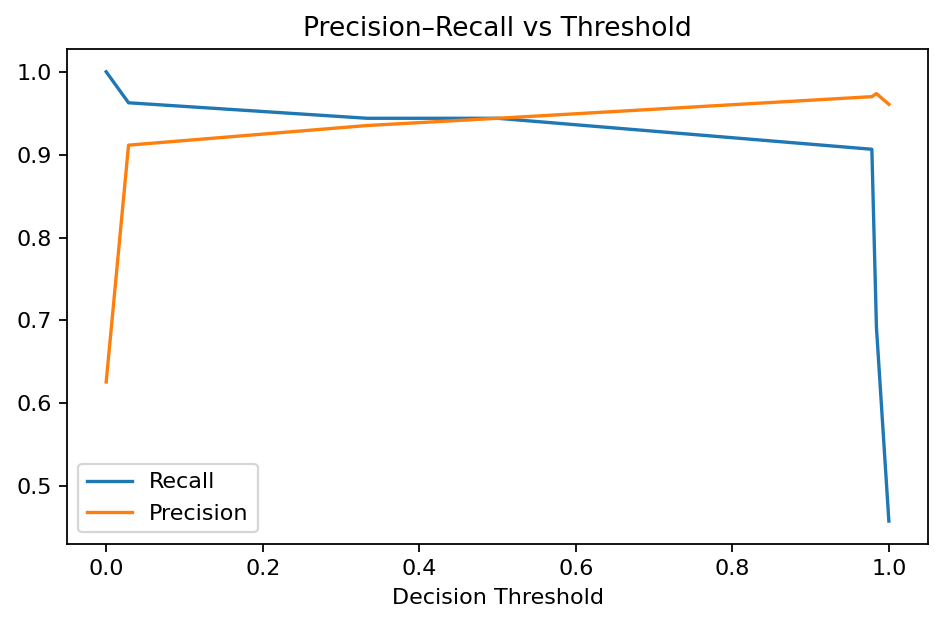

In [59]:
#tradeoff between recall and precision
prec, rec, th = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(th, rec[:-1], label="Recall")
plt.plot(th, prec[:-1], label="Precision")
plt.xlabel("Decision Threshold"); plt.legend()
plt.title("Precision–Recall vs Threshold")
plt.tight_layout()
plt.savefig(VIS_DIR / "09_pr_threshold.png", bbox_inches="tight")
plt.show()


##Calibration Curve

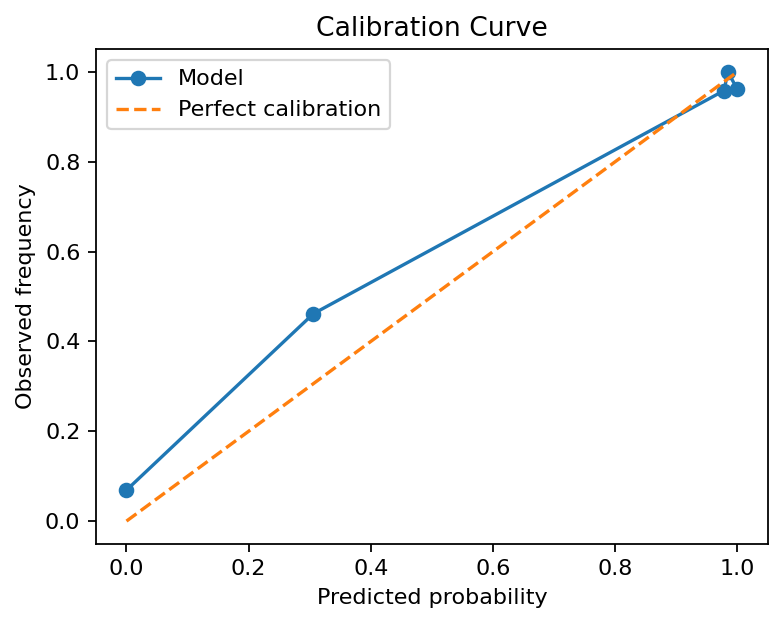

In [60]:
#showing how well predicted probabilities align with reality
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0,1],[0,1],"--", label="Perfect calibration")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Calibration Curve")
plt.legend()
plt.tight_layout()
plt.savefig(VIS_DIR / "10_calibration.png", bbox_inches="tight")
plt.show()


# Decision Tree Visualization

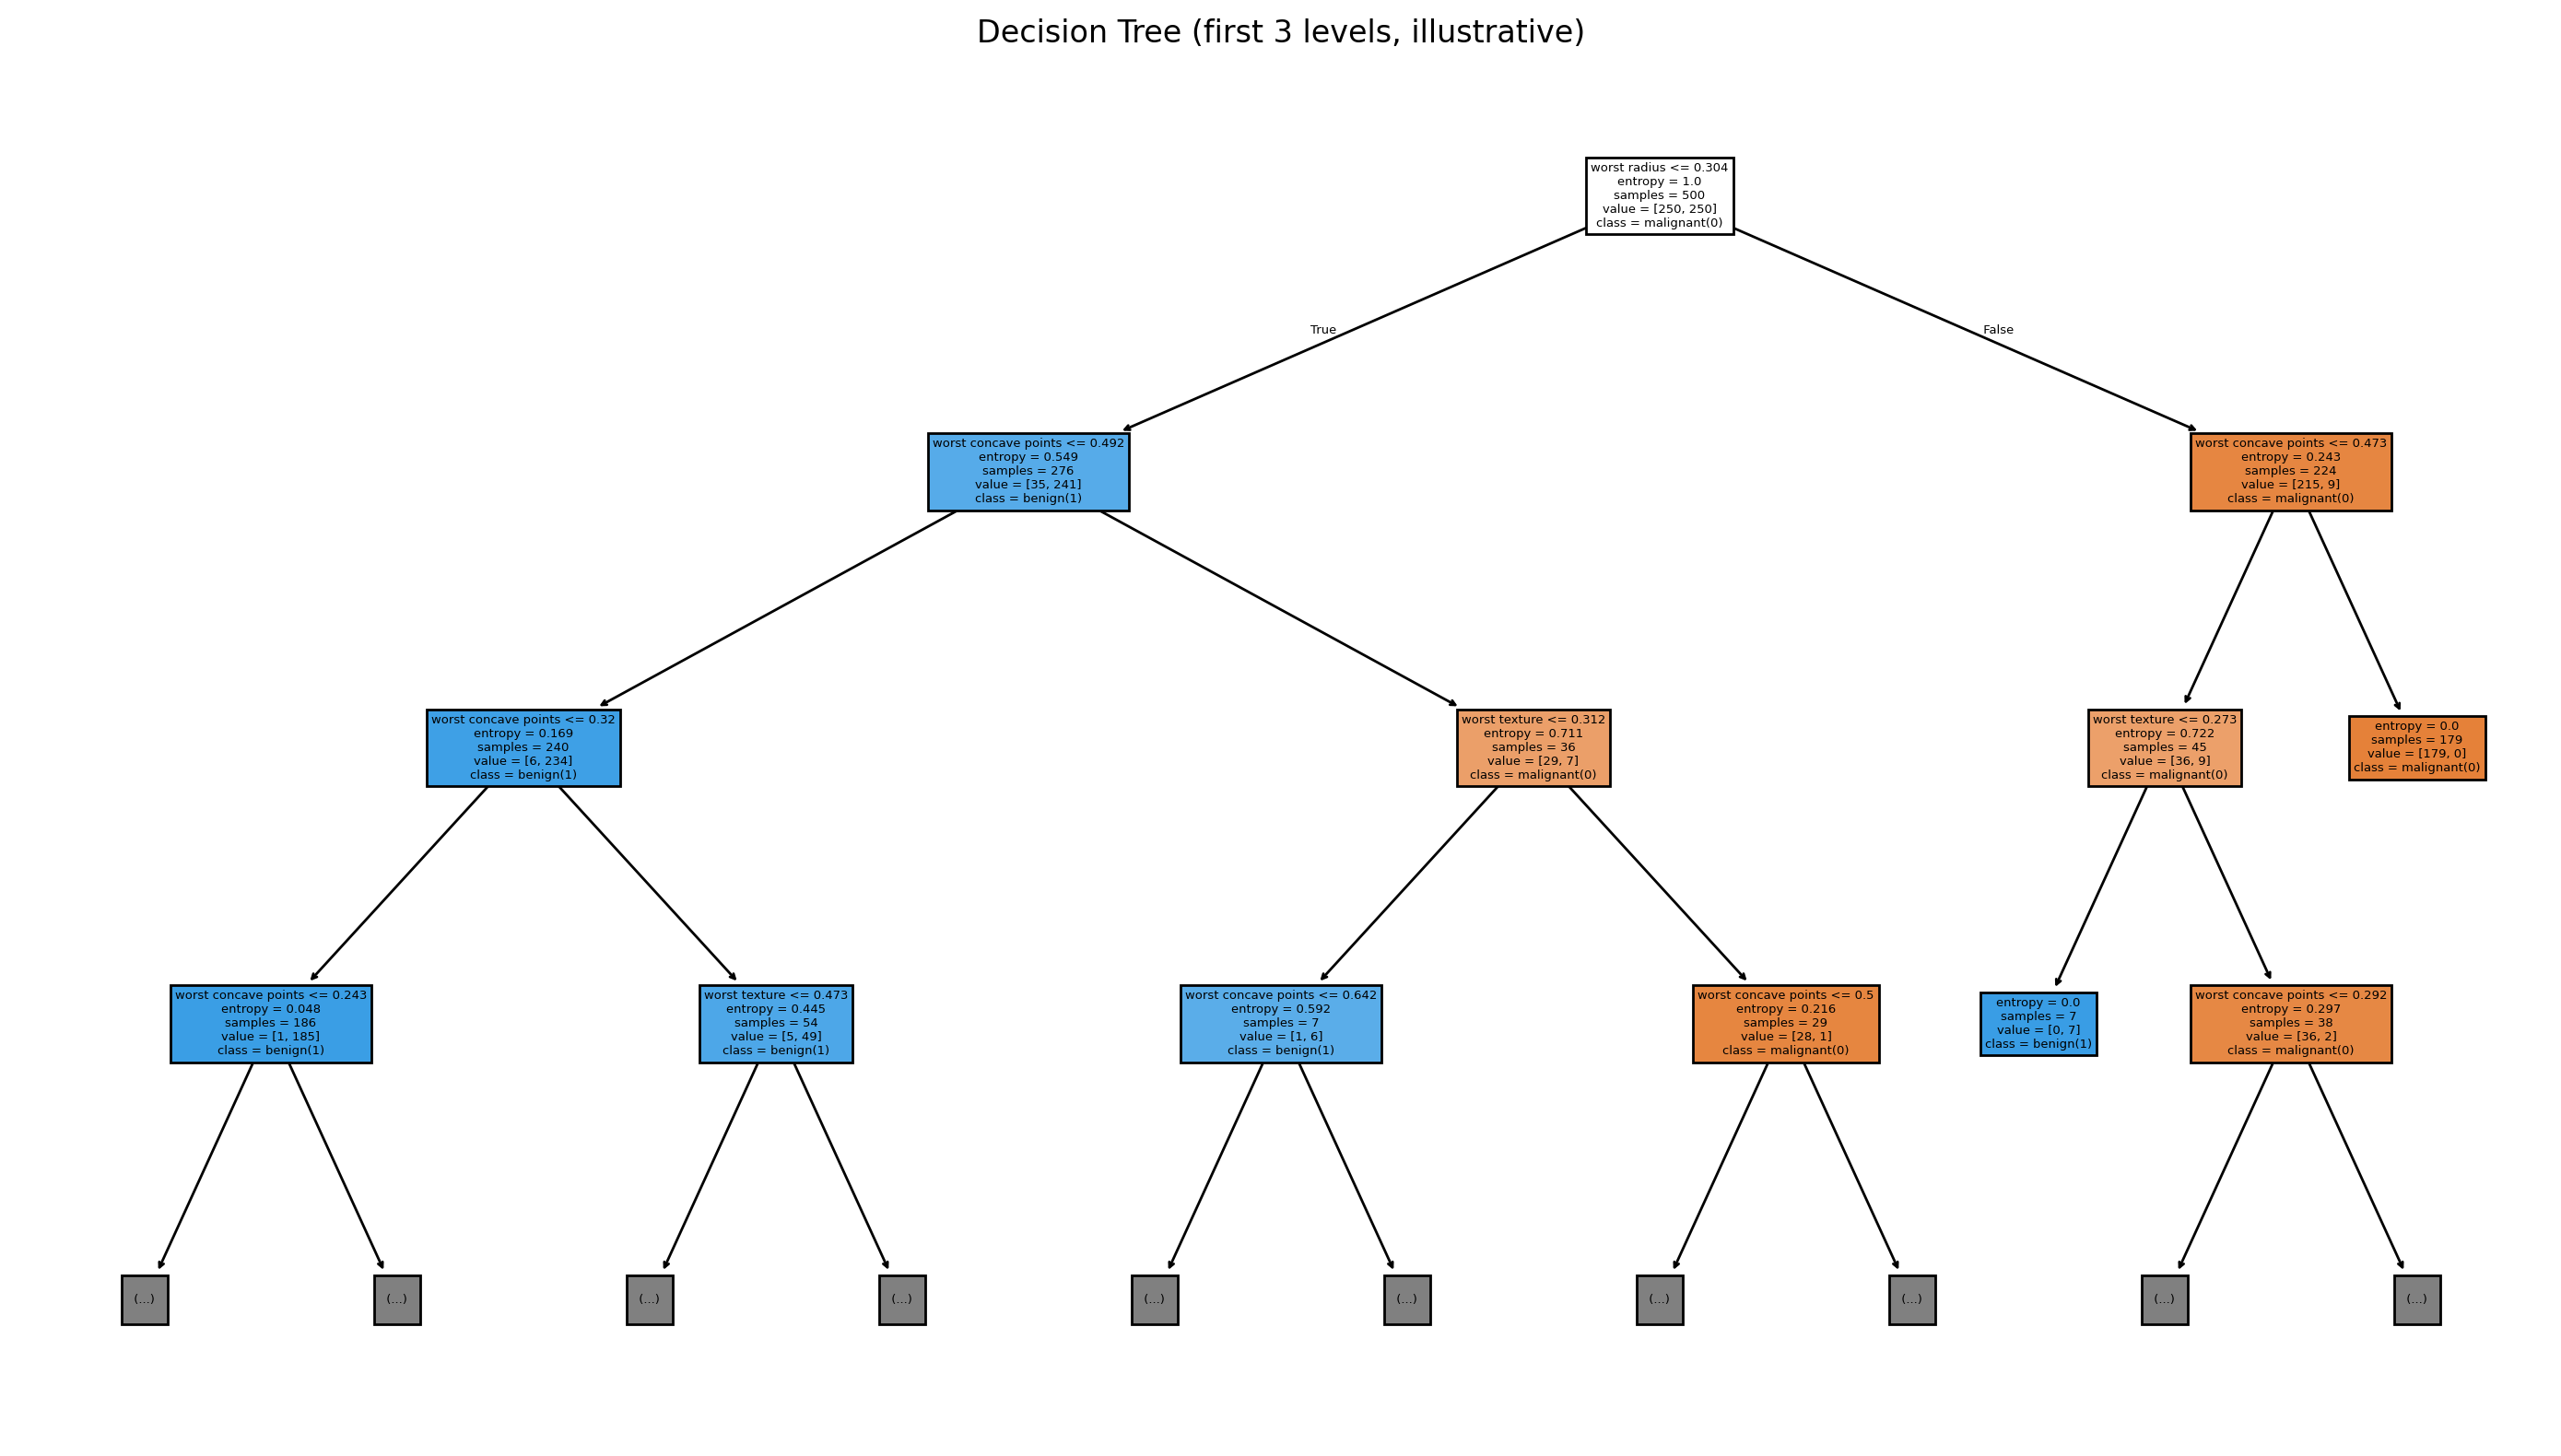

In [50]:
#tuned DT from pipeline
final_tree = best.named_steps["clf"]

plt.figure(figsize=(14, 8), dpi=200)
tree.plot_tree(
    final_tree,
    max_depth=3,   #limit depth for readability
    filled=True,
    feature_names=Xtr_sel.columns,
    class_names=["malignant(0)", "benign(1)"]
)
plt.title("Decision Tree (first 3 levels, illustrative)")
plt.tight_layout()
plt.savefig(VIS_DIR / "00_tree_structure.png", bbox_inches="tight")
plt.show()


#Permutation Feature Importance (Test Set)

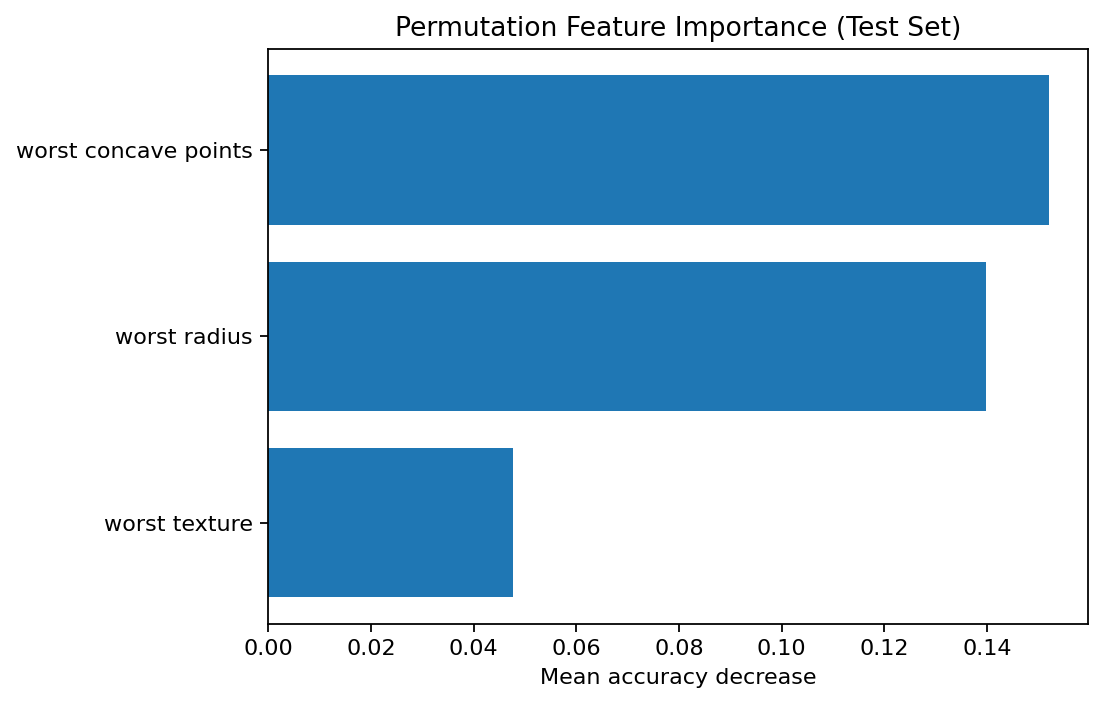

,feature,mean_importance
0,worst concave points,0.152047
1,worst radius,0.139766
2,worst texture,0.047661


In [51]:
#computed on the test set to reflect generalization
perm = permutation_importance(
    best, Xte_sel, y_test, n_repeats=20, random_state=SEED, n_jobs=-1
)

order = np.argsort(perm.importances_mean)[::-1]
feat_rank = Xte_sel.columns[order]
scores = perm.importances_mean[order]

plt.figure(figsize=(7, 4.5))
plt.barh(range(len(feat_rank)), scores)
plt.gca().invert_yaxis()
plt.yticks(range(len(feat_rank)), feat_rank)
plt.xlabel("Mean accuracy decrease")
plt.title("Permutation Feature Importance (Test Set)")
plt.tight_layout()
plt.savefig(VIS_DIR / "04_perm_importance.png", dpi=200, bbox_inches="tight")
plt.show()


pd.DataFrame({"feature": feat_rank, "mean_importance": scores}).head(10) #just a table for keeping things tidy


# SHAP Explainability (Beeswarm, Bar, Dependence Plot)

sv_pos shape: (171, 3)
X_plot shape: (171, 3)


/tmp/ipython-input-956404998.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_pos, X_plot, show=False)


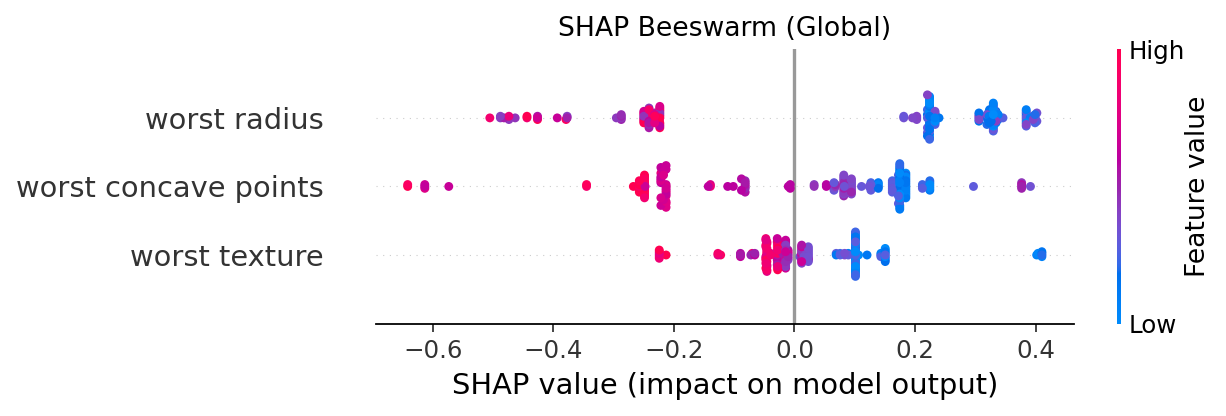

/tmp/ipython-input-956404998.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_pos, X_plot, plot_type="bar", show=False)


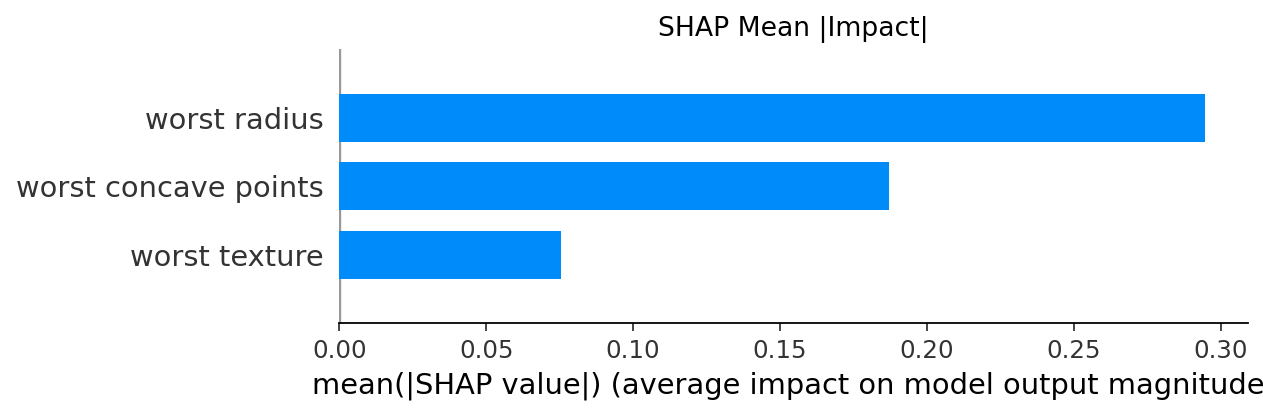

<Figure size 1024x768 with 0 Axes>

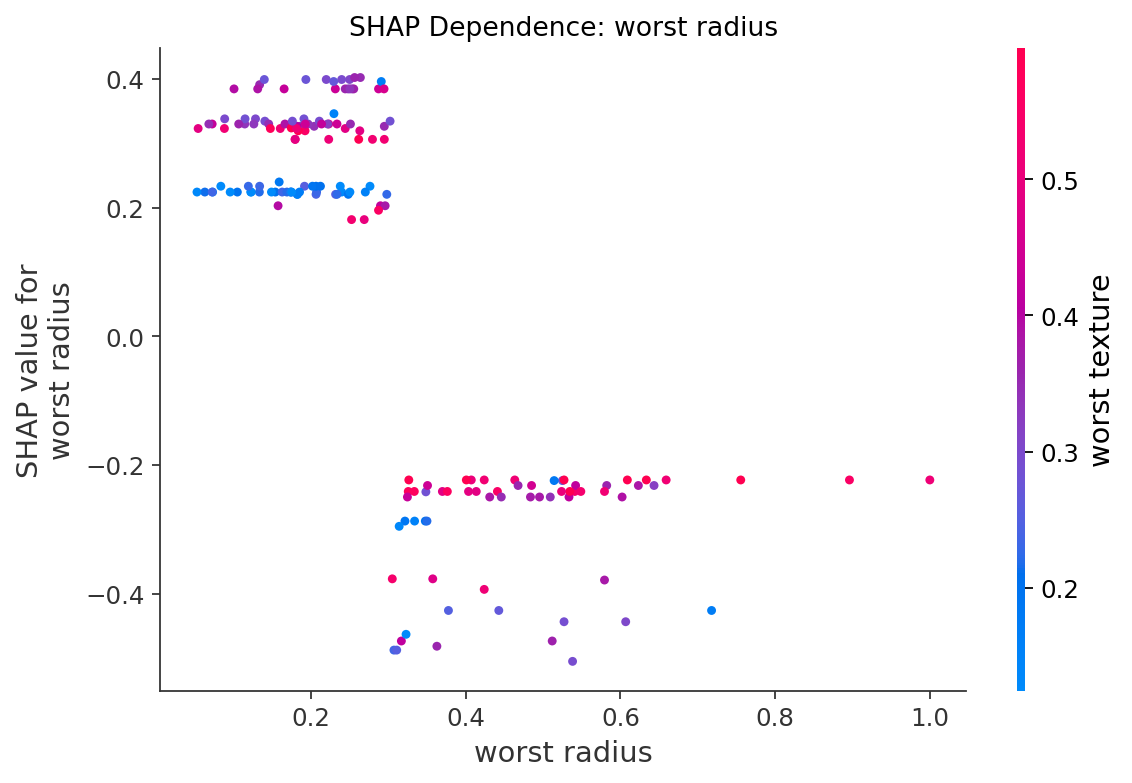

In [53]:
tree_clf = best.named_steps["clf"]

#explaining a sample
X_plot = Xte_sel.sample(n=min(300, len(Xte_sel)), random_state=SEED)

#building explainer
explainer = shap.TreeExplainer(tree_clf)
shap_vals = explainer.shap_values(X_plot)

def get_positive_class_shap(shap_vals):
    """
    Return a 2-D array (n_samples, n_features) with SHAP values for the positive class.
    Works whether SHAP returns a list of arrays or a 3-D array.
    """
    #old style: list of arrays [class0, class1]
    if isinstance(shap_vals, list):
        #positive class is index 1 for binary classifiers
        return shap_vals[1]
    #newer style: one 3-D array (n_samples, n_features, n_classes)
    if isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 3 and shap_vals.shape[-1] == 2:
        return shap_vals[..., 1]
    #already 2-D
    if isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 2:
        return shap_vals
    raise ValueError(f"Unexpected SHAP shape: {getattr(shap_vals, 'shape', None)}")

sv_pos = get_positive_class_shap(shap_vals)

print("sv_pos shape:", sv_pos.shape)       #(n_samples, n_features)
print("X_plot shape:", X_plot.shape)       #(n_samples, n_features)

#beeswarm
plt.figure()
shap.summary_plot(sv_pos, X_plot, show=False)
plt.title("SHAP Beeswarm (Global)")
plt.tight_layout()
plt.savefig(VIS_DIR / "05_shap_beeswarm.png", bbox_inches="tight")
plt.show()

#bar chart/summary plot
plt.figure()
shap.summary_plot(sv_pos, X_plot, plot_type="bar", show=False)
plt.title("SHAP Mean |Impact|")
plt.tight_layout()
plt.savefig(VIS_DIR / "06_shap_bar.png", bbox_inches="tight")
plt.show()


#dependence plot
top_idx = np.argsort(np.abs(sv_pos).mean(0))[::-1][0]
top_feat = X_plot.columns[top_idx]
plt.figure()
shap.dependence_plot(top_feat, sv_pos, X_plot, show=False)
plt.title(f"SHAP Dependence: {top_feat}")
plt.tight_layout()
plt.savefig(VIS_DIR / "07_shap_dependence.png", bbox_inches="tight")
plt.show()


#Partial Dependence & ICE Plots (Top Features)

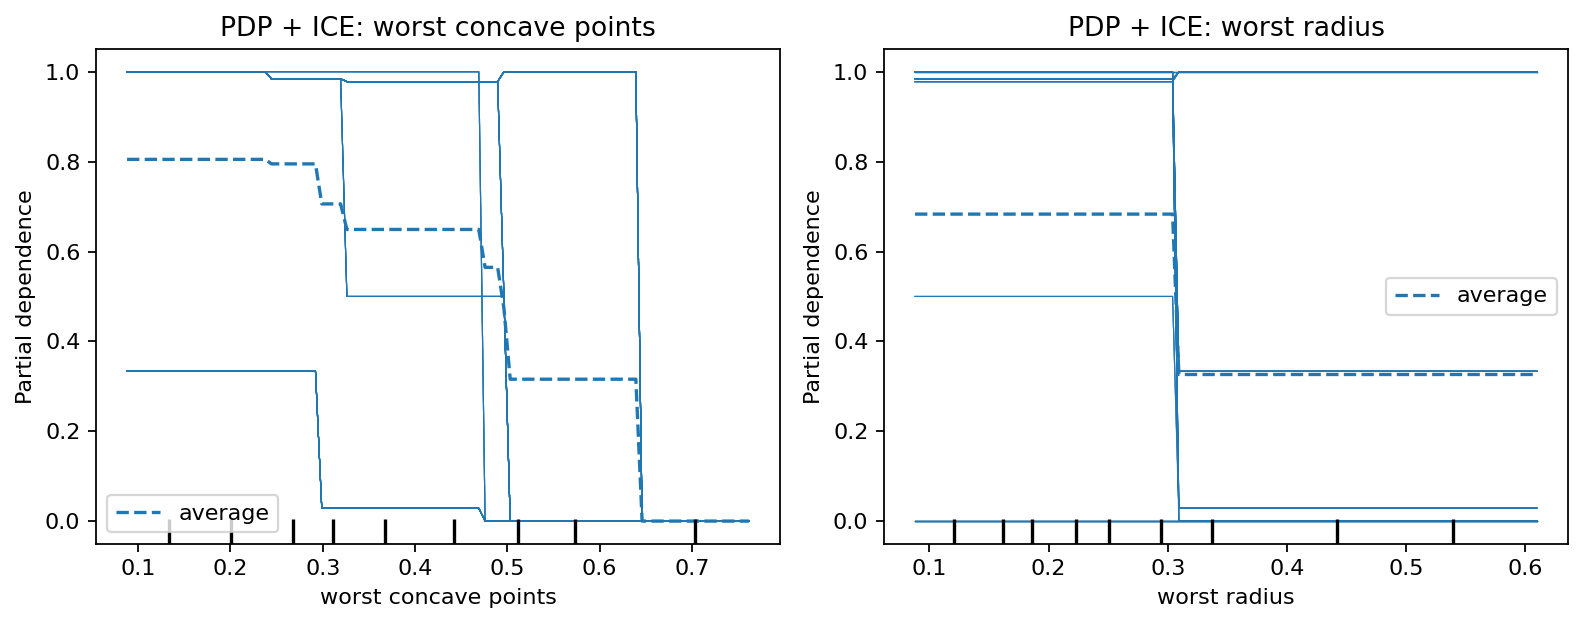

In [63]:
from sklearn.inspection import PartialDependenceDisplay

# Take top 2 features from permutation importance (or SHAP)
top2 = list(Xte_sel.columns[np.argsort(perm.importances_mean)[::-1][:2]])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, feat in enumerate(top2):
    PartialDependenceDisplay.from_estimator(
        best.named_steps["clf"],  # the DT inside your pipeline
        Xte_sel,
        [feat],
        kind="both",   # PDP + ICE
        ax=ax[i]
    )
    ax[i].set_title(f"PDP + ICE: {feat}")

plt.tight_layout()
plt.savefig(VIS_DIR / "08_pdp_ice.png", bbox_inches="tight")
plt.show()


#LIME

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


[('worst concave points > 0.57', -0.6632058561114704), ('worst texture > 0.46', -0.15865235299741315), ('0.25 < worst radius <= 0.39', -0.04566386014769553)]


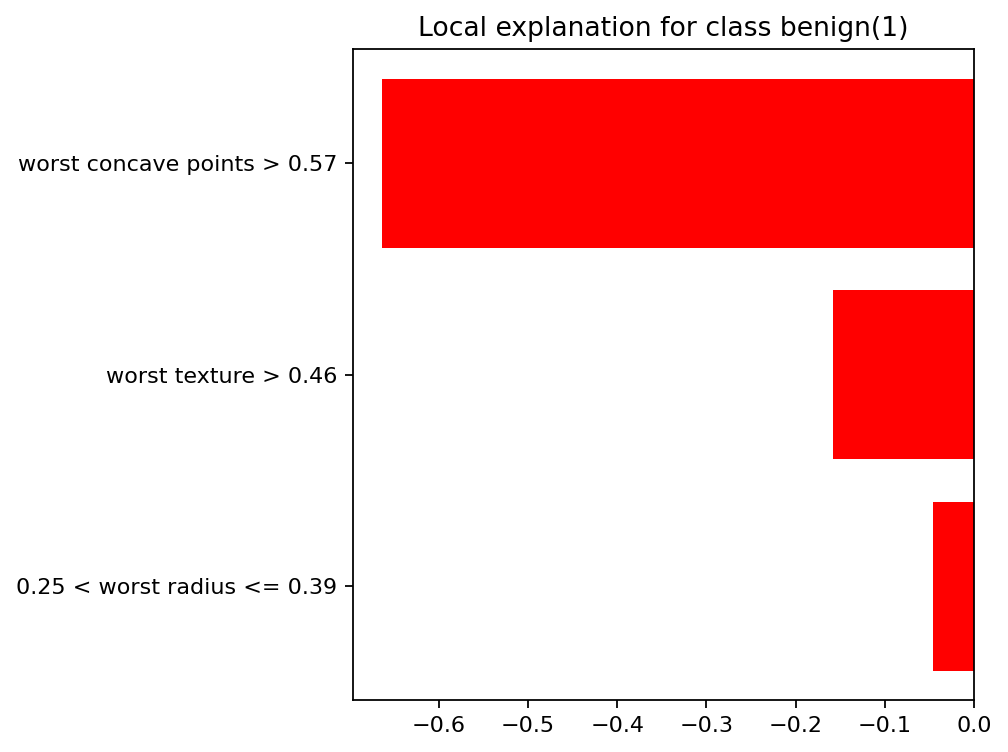

In [64]:
class_names = ["malignant(0)", "benign(1)"]

lime_explainer = LimeTabularExplainer(
    training_data=Xtr_sel.values,
    feature_names=Xtr_sel.columns.tolist(),
    class_names=class_names,
    discretize_continuous=True,
    mode="classification"
)

#picking a random test instance to explain
i = 0
x0 = Xte_sel.iloc[i].values
exp = lime_explainer.explain_instance(
    data_row=x0,
    predict_fn=best.predict_proba,
    num_features=min(10, Xte_sel.shape[1])
)

exp.save_to_file(str(VIS_DIR / "09_lime_example.html")) #saving an html
print(exp.as_list())
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.savefig(VIS_DIR / "09_lime_example.png")
plt.show()

